In [2]:
!pip install tensorflow_datasets


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

KeyError: "There is no item named 'PetImages\\\\Cat\\\\0.jpg' in the archive"

In [ ]:
class_names = info.features['label'].names
class_names

In [6]:
for i, example in enumerate(dataset['train']):
  # example = (image, label)
  image, label = example
  save_dir = './cats_vs_dogs/train/{}'.format(class_names[label])
  os.makedirs(save_dir, exist_ok=True)

  filename = save_dir + "/" + "{}_{}.jpg".format(class_names[label], i)
  tf.keras.preprocessing.image.save_img(filename, image.numpy())
  # print(filename)
  # break

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [8]:
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2, rotation_range=10,
                              width_shift_range=0.1, height_shift_range=0.1,
                             shear_range=0.1, zoom_range=0.10, horizontal_flip=True)

train_generator = datagen.flow_from_directory('/content/cats_vs_dogs/train',
                                              target_size = (150, 150),
                                              batch_size=32,
                                              class_mode='binary',
                                              subset='training')

validation_generator = datagen.flow_from_directory('/content/cats_vs_dogs/train',
                                              target_size = (150, 150),
                                              batch_size=32,
                                              class_mode='binary',
                                              subset='validation')

Found 18611 images belonging to 2 classes.
Found 4651 images belonging to 2 classes.


In [9]:
from keras.backend import batch_normalization
model = Sequential()

# 1st layer CNN
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# 2nd layer CNN
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(2))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# 3rd Layer
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(2))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
582/582 [==============================] - 167s 275ms/step - loss: 0.6465 - accuracy: 0.6309 - val_loss: 0.5860 - val_accuracy: 0.7005
Epoch 2/10
582/582 [==============================] - 170s 293ms/step - loss: 0.5575 - accuracy: 0.7121 - val_loss: 0.5300 - val_accuracy: 0.7203
Epoch 3/10
582/582 [==============================] - 161s 278ms/step - loss: 0.4930 - accuracy: 0.7604 - val_loss: 0.4740 - val_accuracy: 0.7809
Epoch 4/10
582/582 [==============================] - 161s 277ms/step - loss: 0.4485 - accuracy: 0.7865 - val_loss: 0.4777 - val_accuracy: 0.7730
Epoch 5/10
582/582 [==============================] - 162s 278ms/step - loss: 0.4292 - accuracy: 0.8034 - val_loss: 0.4016 - val_accuracy: 0.8181
Epoch 6/10
582/582 [==============================] - 161s 276ms/step - loss: 0.4026 - accuracy: 0.8177 - val_loss: 0.3712 - val_accuracy: 0.8327
Epoch 7/10
582/582 [==============================] - 162s 279ms/step - loss: 0.3870 - accuracy: 0.8244 - val_loss: 0.3889 -

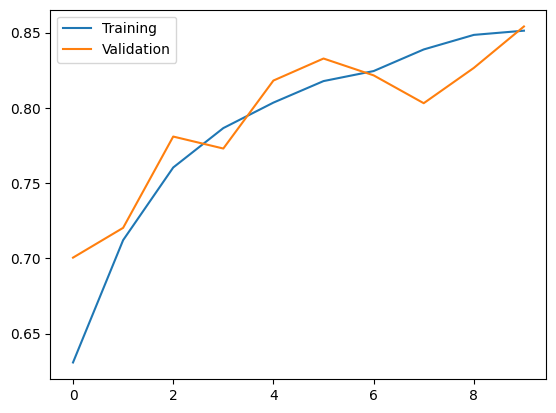

In [12]:
history.history

plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend(['Training', 'Validation'])

In [13]:
model.save('cats_vs_dogs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
model_load = tf.keras.models.load_model('cats_vs_dogs.h5')

In [15]:
import requests
from PIL import Image
from tensorflow.keras.preprocessing import image

img_url = "https://i.natgeofe.com/n/548467d8-c5f1-4551-9f58-6817a8d2c45e/NationalGeographic_2572187_square.jpg"
img = Image.open(requests.get(img_url, stream=True).raw).resize((150, 150))

image_array = image.img_to_array(img)

img = np.expand_dims(image_array, axis=0)

img = img/255

prediction = model.predict(img)

TH = 0.5
prediction = int(prediction[0][0]>TH)
classes = {v:k for k,v in train_generator.class_indices.items()}
classes[prediction]

1/1 [==============================] - 0s 316ms/step


'cat'

In [1]:
model.save('cats_vs_dogs_saved_model')

NameError: name 'model' is not defined